<a href="https://colab.research.google.com/github/souravs17031999/Projects-kaggle-problems-60daysofudacity/blob/master/NLPproject_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project : NLP Emotion recognition 

## Importing all the packages 

In [0]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
import nltk

In [0]:
import re
import numpy as np
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
%matplotlib inline

import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

## Loading the dataset

In [0]:
### Helper functions
import pickle

def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))


def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


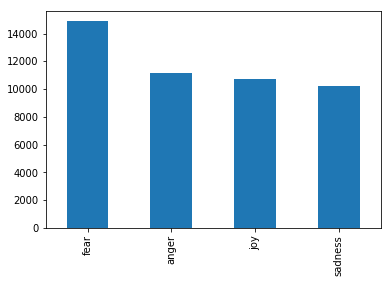

In [35]:
# load data
text_data = load_from_pickle(directory="/content/drive/My Drive/train.pkl")
text_data.emotion.value_counts().plot.bar()

In [36]:
text_data.head(10)

,id,tweets,emotion,intensity
0,10000,how the fu k who the heck moved my fridge shou...,anger,0.938
1,10001,so my indian uber driver just called someone t...,anger,0.896
2,10002,uk i asked for my parcel to be delivered to a ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,don t join they put the phone down on you talk...,anger,0.896
5,10005,my blood is boiling,anger,0.875
6,10006,when you ve still got a whole season of wentwo...,anger,0.875
7,10007,uk why does tracking show my equipment deliver...,anger,0.875
8,10008,legit why i am so furious with him people are ...,anger,0.875
9,10009,how is it suppose to work if you do that wtf d...,anger,0.875


In [37]:
text_data.shape

(46969, 4)

In [38]:
len(text_data['tweets'][0])

84

In [39]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data preprocessing 

In [0]:
text_data["token_size"] = text_data["tweets"].apply(lambda x: len(x.split(' ')))
text_data = text_data.loc[text_data['token_size'] < 70].copy()

In [0]:
words_list = text_data["tweets"].values.tolist()


In [0]:
words = []
for i in words_list:
  words.append(nltk.word_tokenize(i))

## Constructing dictionery for mapping words to index

In [0]:
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

In [0]:
inputs = ConstructVocab(words_list)

In [47]:
inputs.vocab[0:10]

['a',
 'aa',
 'aaa',
 'aaron',
 'aateam',
 'ab',
 'abby',
 'aber',
 'aberdeen',
 'abhijit']

In [0]:
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in words_list]

In [49]:
input_tensor[0:2]

[[3420,
  7358,
  2781,
  3870,
  8087,
  7358,
  3269,
  4695,
  4748,
  2750,
  6602,
  3479,
  3968,
  7358,
  4012,
  2033,
  280,
  4308],
 [6770,
  4748,
  3582,
  7672,
  2080,
  3859,
  1054,
  6807,
  7358,
  4755,
  8170,
  3503,
  3479,
  7977,
  7203,
  3557,
  1,
  4701,
  7831,
  3479,
  1698,
  3226,
  3847,
  5233,
  1955]]

In [50]:
def max_length(tensor):
    return max(len(t) for t in tensor)
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)  

33


In [0]:
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [0]:
# inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

In [53]:
input_tensor[0:2]

[array([3420, 7358, 2781, 3870, 8087, 7358, 3269, 4695, 4748, 2750, 6602,
        3479, 3968, 7358, 4012, 2033,  280, 4308,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 array([6770, 4748, 3582, 7672, 2080, 3859, 1054, 6807, 7358, 4755, 8170,
        3503, 3479, 7977, 7203, 3557,    1, 4701, 7831, 3479, 1698, 3226,
        3847, 5233, 1955,    0,    0,    0,    0,    0,    0,    0,    0])]

In [0]:
### convert targets to one-hot encoding vectors
emotions = list(set(text_data.emotion.unique()))
num_emotions = len(emotions)
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in text_data[['emotion']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [55]:
target_tensor

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

In [57]:
text_data[0:3]

,id,tweets,emotion,intensity,token_size
0,10000,how the fu k who the heck moved my fridge shou...,anger,0.938,18
1,10001,so my indian uber driver just called someone t...,anger,0.896,25
2,10002,uk i asked for my parcel to be delivered to a ...,anger,0.896,19


In [73]:
text_data["emotion"]

0        anger
1        anger
2        anger
3        anger
4        anger
5        anger
6        anger
7        anger
8        anger
9        anger
10       anger
11       anger
12       anger
13       anger
14       anger
15       anger
16       anger
17       anger
18       anger
19       anger
20       anger
21       anger
22       anger
23       anger
24       anger
25       anger
26       anger
27       anger
28       anger
29       anger
         ...  
46939      joy
46940      joy
46941      joy
46942      joy
46943      joy
46944      joy
46945      joy
46946      joy
46947      joy
46948      joy
46949      joy
46950      joy
46951      joy
46952      joy
46953      joy
46954      joy
46955      joy
46956      joy
46957      joy
46958      joy
46959      joy
46960      joy
46961      joy
46962      joy
46963      joy
46964      joy
46965      joy
46966      joy
46967      joy
46968      joy
Name: emotion, Length: 46969, dtype: object

In [76]:
get_emotion = lambda t: np.argmax(t)
get_emotion(target_tensor[1])

0

In [77]:
emotion_dict = {0: 'anger', 1: 'fear', 2: 'sadness', 3: 'joy'}
emotion_dict[get_emotion(target_tensor[0])]

'anger'

In [93]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
print(f"training length: {len(input_tensor_train)}")
print(f"training target length: {len(target_tensor_train)}")
print(f"validation length: {len(input_tensor_val)}")
print(f"validation target length: {len(target_tensor_val)}")
print(f"testing length: {len(input_tensor_test)}")
print(f"testing target length: {len(target_tensor_test)}")

training length: 37575
training target length: 37575
validation length: 4697
validation target length: 4697
testing length: 4697
testing target length: 4697


In [0]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = num_emotions

In [0]:
# convert the data to tensors and pass to the Dataloader 
# to create an batch iterator

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [0]:
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)

train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [82]:
print(len(train_dataset))

587


In [83]:
val_dataset.batch_size

64

In [0]:
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden  

In [0]:
### sort batch function to be able to use with pad_packed_sequence
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq) to (seq x batch)

In [86]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

# obtain one sample from the data iterator
it = iter(train_dataset)
x, y, x_len = next(it)

# sort the batch first to be able to use with pac_pack sequence
xs, ys, lens = sort_batch(x, y, x_len)

print("Input size: ", xs.size())

output, _ = model(xs.to(device), lens, device)
print("Output size : ", output.size())
print(device)

Input size:  torch.Size([33, 64])
Output size :  torch.Size([64, 4])
cuda:0


In [0]:
### Enabling cuda
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

### loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

def loss_function(y, prediction):
    """ CrossEntropyLoss expects outputs and class indices as target """
    # convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target) 
    return loss   #TODO: refer the parameter of these functions as the same
    
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

In [89]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        predictions, _ = model(inp.permute(1 ,0).to(device), lens, device) # TODO:don't need _   
              
        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))        
        total_loss += batch_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))
            
    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(val_dataset):        
        predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             total_loss / TRAIN_N_BATCH, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.0069
Epoch 1 Batch 100 Val. Loss 0.0076
Epoch 1 Batch 200 Val. Loss 0.0026
Epoch 1 Batch 300 Val. Loss 0.0120
Epoch 1 Batch 400 Val. Loss 0.0077
Epoch 1 Batch 500 Val. Loss 0.0134
Epoch 1 Loss 0.0122 -- Train Acc. 97.0000 -- Val Acc. 97.0000
Time taken for 1 epoch 25.748496770858765 sec

Epoch 2 Batch 0 Val. Loss 0.0056
Epoch 2 Batch 100 Val. Loss 0.0006
Epoch 2 Batch 200 Val. Loss 0.0115
Epoch 2 Batch 300 Val. Loss 0.0281
Epoch 2 Batch 400 Val. Loss 0.0002
Epoch 2 Batch 500 Val. Loss 0.0144
Epoch 2 Loss 0.0082 -- Train Acc. 98.0000 -- Val Acc. 97.0000
Time taken for 1 epoch 25.93695640563965 sec

Epoch 3 Batch 0 Val. Loss 0.0046
Epoch 3 Batch 100 Val. Loss 0.0001
Epoch 3 Batch 200 Val. Loss 0.0001
Epoch 3 Batch 300 Val. Loss 0.0030
Epoch 3 Batch 400 Val. Loss 0.0051
Epoch 3 Batch 500 Val. Loss 0.0324
Epoch 3 Loss 0.0102 -- Train Acc. 97.0000 -- Val Acc. 97.0000
Time taken for 1 epoch 26.151772022247314 sec

Epoch 4 Batch 0 Val. Loss 0.0284
Epoch 4 Batch 100

In [90]:
model.parameters

<bound method Module.parameters of EmoGRU(
  (embedding): Embedding(8347, 256)
  (dropout): Dropout(p=0.5)
  (gru): GRU(256, 1024)
  (fc): Linear(in_features=1024, out_features=4, bias=True)
)>

In [95]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

device = "cuda" # we don't need GPU to do testing
model.to("cuda")

for (batch, (inp, targ, lens)) in enumerate(test_dataset):          
    predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
    batch_accuracy = accuracy(targ.to(device), predictions)
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy.cpu().detach().numpy() / TEST_N_BATCH)

Test Accuracy:  98.0
